In [1]:
from transformers import RobertaTokenizer, BertModel

import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch
import functools

import torch
import torchmetrics

import pytorch_lightning as pl
import torch.nn as nn


import pandas as pd
import matplotlib.pyplot as plt
import functools
#from IPython.display import display
from tqdm.notebook import tqdm
from termcolor import cprint



### Charger le model

In [4]:
juribert_tokenizer = RobertaTokenizer.from_pretrained('LegalTokenizer')
juribert_model = BertModel.from_pretrained('juribert_small',local_files_only=True)


Some weights of BertModel were not initialized from the model checkpoint at juribert_small and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Afficher les détails du modèle


In [3]:
# Afficher les détails du modèle
display(juribert_model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32000, 512, padding_idx=0)
    (position_embeddings): Embedding(512, 512)
    (token_type_embeddings): Embedding(1, 512)
    (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=512, out_features=512, bias=True)
            (key): Linear(in_features=512, out_features=512, bias=True)
            (value): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=512, out_features=512, bias=True)
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [4]:
# Définir un exemple de texte
text = "Suis-je payé pendant la procédure du trajet de réintégration"

# Tokeniser le texte
tokens = juribert_tokenizer(text, return_tensors='pt')

# Obtenir les embeddings des tokens
with torch.no_grad():
    outputs = juribert_model(**tokens)

# Afficher les détails des embeddings
print(outputs.last_hidden_state.shape)  # Taille des embeddings des tokens

# Afficher les détails des sorties du modèle
for key, value in outputs.items():
    print(f"{key}: {value.shape}")


torch.Size([1, 14, 512])
last_hidden_state: torch.Size([1, 14, 512])
pooler_output: torch.Size([1, 512])


### Créer le dataset

In [5]:
# obliger de changer comme ça les données pour pouvoir utiliser DataLoader de torch avec csv file
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

train_dataset = CustomDataset('questions_train.csv')
test_dataset = CustomDataset('questions_test.csv')

In [6]:
# Display the head of the dataset
display(train_dataset.data.head())

,id,category,subcategory,question,extra_description,article_ids
0,1102,Travail,Travail et parentalité,Je suis travailleur salarié(e). Puis-je refuse...,Pendant la grossesse,"22225,22226,22227,22228,22229,22230,22231,2223..."
1,91,Argent,Dettes,Peut-on saisir tous mes revenus ?,"Procédures de récupération des dettes, Récupér...","5853,5854,5855"
2,474,Famille,Situation de couples,Je suis marié(e). Nous sommes mariés. Dois-je ...,Mariage,"1096,1097,1098,1108,1109,1110"
3,836,Logement,Location en Wallonie,Je mets un kot en location (bail de droit comm...,"Mettre un logement en location (Wallonie), Doi...","12012,12030,12031,12032,12033,12034,12035"
4,1079,Travail,Maladie - incapacité de travail,Suis-je payé pendant la procédure du trajet de...,Rupture du contrat de travail pour force majeu...,"21114,21115,21116,21117,21118,21119,21120,2112..."


In [11]:
#Quelque exemple de phrase du DF
for idx in range(5):
    question_content = train_dataset.data.iloc[idx]["question"]
    cprint(f"{idx + 1}. {question_content}\n", "black", on_color="on_white")



1. Je suis travailleur salarié(e). Puis-je refuser de faire des heures supplémentaires ou de travailler de nuit ?

2. Peut-on saisir tous mes revenus ?

3. Je suis marié(e). Nous sommes mariés. Dois-je reconnaître mon enfant ?

4. Je mets un kot en location (bail de droit commun). Pour quels logements le permis de location est-il nécessaire en Wallonie ?

5. Suis-je payé pendant la procédure du trajet de réintégration ?



In [8]:
train_dataset.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886 entries, 0 to 885
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 886 non-null    int64 
 1   category           886 non-null    object
 2   subcategory        886 non-null    object
 3   question           886 non-null    object
 4   extra_description  791 non-null    object
 5   article_ids        886 non-null    object
dtypes: int64(1), object(5)
memory usage: 41.7+ KB


In [140]:
test_dataset.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 222 non-null    int64 
 1   category           222 non-null    object
 2   subcategory        222 non-null    object
 3   question           222 non-null    object
 4   extra_description  199 non-null    object
 5   article_ids        222 non-null    object
 6   labels             222 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 12.3+ KB


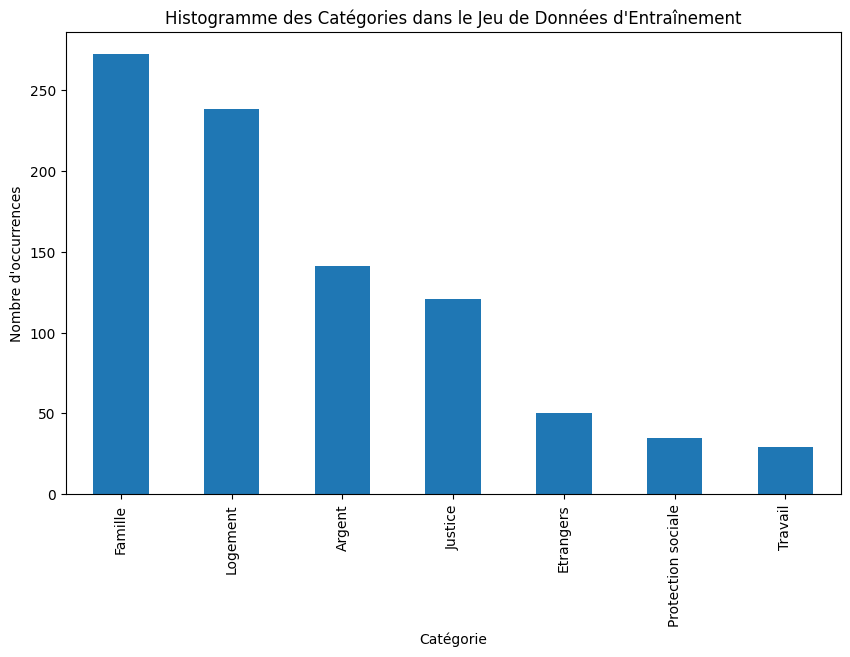

In [8]:
plt.figure(figsize=(10, 6))
train_dataset.data['category'].value_counts().plot(kind='bar')
plt.title('Histogramme des Catégories dans le Jeu de Données d\'Entraînement')
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'occurrences')
plt.show()

In [13]:
# Notamment, aucune phrase ne comporte plus de 512 caractères, et donc aucune phrase ne comportera plus de 512 tokens:
train_dataset.data['question_length'] = train_dataset.data['question'].apply(lambda x: len(x))  # Utilisez split() pour compter les mots
cprint(train_dataset.data["question_length"].any()>512, "green", attrs=["bold"], on_color="on_white")



False


####  Définir la correspondance des catégories avec des valeurs numériques


In [20]:
# Définir la correspondance des catégories avec des valeurs numériques
category_mapping = {'Travail': 0, 'Argent': 1, 'Famille': 2, 'Logement': 3, 'Protection sociale': 4, 'Justice': 5, 'Etrangers': 6}

# Appliquer la correspondance au DataFrame
train_dataset.data['labels'] = train_dataset.data['category'].map(category_mapping)
test_dataset.data['labels'] = test_dataset.data['category'].map(category_mapping)

# Vérifier les valeurs uniques dans la nouvelle colonne
unique_categories_numeric = train_dataset.data['labels'].unique()
cprint(f'Nombre de classes : {unique_categories_numeric}', "green", attrs=["bold"], on_color="on_white")

num_category= train_dataset.data["labels"].nunique()
cprint(f'Nombre de classes : {num_category}', "red", attrs=["bold"], on_color="on_white")



Nombre de classes : [0 1 2 3 4 5 6]
Nombre de classes : 7


### Créer le DataLoader et création des IDs des questions


In [23]:
# Utilisons maintenant Juribert afin d’obtenir une représentation vectorielle de chacun des messages!
def tokernize_batch(samples, tokenizer):
    text = [sample["question"] for sample in samples]
    category = [sample['category'] for sample in samples]
    labels = torch.tensor([sample["labels"] for sample in samples])


    tokens = juribert_tokenizer(text, padding='longest', return_tensors='pt')
    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask,"labels": labels, "category": category, "sentences": text}


In [22]:
#definir le batch size
batch_size = 2
train_DataLoader = DataLoader(train_dataset, 
                              collate_fn=functools.partial(tokernize_batch, tokenizer = juribert_tokenizer), 
                              batch_size=batch_size,
                              shuffle=True)
batch = next(iter(train_DataLoader))  
batch

{'input_ids': tensor([[   0,   53, 5639,  416,  293, 4200,  300,  487,  321, 5570, 5685,    2,
             1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1],
         [   0,   48,  273, 3414,  391,  666,  374, 8250, 1885,   18,  225,   52,
          1065,   17,  989, 5708,  502, 4893, 1055,  436, 4659,  302, 5808,  969,
          5685,    2]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1]]),
 'labels': tensor([1, 2]),
 'category': ['Argent', 'Famille'],
 'sentences': ['Quel est le rôle du juge des saisies ?',
  'Les parents ne sont pas mariés ensemble. Puis-je reconnaître mon enfant avant sa naissance et comment faire ?']}

### Test decodage 

In [26]:
cprint("\n".join(juribert_tokenizer.batch_decode(batch["input_ids"])), "red", attrs=["bold"], on_color="on_white")



<s>Quel est le rôle du juge des saisies?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s>Les parents ne sont pas mariés ensemble. Puis-je reconnaître mon enfant avant sa naissance et comment faire?</s>


In [31]:
test_DataLoader = DataLoader(test_dataset, 
                              collate_fn=functools.partial(tokernize_batch, tokenizer = juribert_tokenizer), 
                              batch_size= batch_size,
                              shuffle=False)

### Créer les DataLoader avec PytorchLightning: une autre méthode



In [32]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, train_csv, test_csv, tokenizer, batch_size=32, num_workers=4):
        super().__init__()
        self.train_csv = train_csv
        self.test_csv = test_csv
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.num_workers = num_workers

    # ...

    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          collate_fn=functools.partial(tokernize_batch, tokenizer = self.tokenizer), 
                          batch_size=self.batch_size,
                          shuffle=True
                          )

    def val_dataloader(self):
        return DataLoader(self.test_dataset, 
                          collate_fn=functools.partial(tokernize_batch, tokenizer = self.tokenizer), 
                          batch_size=self.batch_size,
                          shuffle=False
                          )


### Création du modèle avec PytorchLightning



In [28]:
# Définition de la classe JuribertClassifier qui hérite de pl.LightningModule
# Cette classe est utilisée pour créer un modèle de classification basé sur le modèle pré-entraîné Juribert


class JuribertClassifier(pl.LightningModule):
    """Cette classe est utilisée pour créer un modèle de classification basé sur le modèle pré-entraîné Juribert
    """
    def __init__(self, juribert_model, juribert_tokenizer, nclasses=7, dropout_rate=0.1, learning_rate=3e-5):
        super(JuribertClassifier, self).__init__()
        self.juribert_tokenizer = juribert_tokenizer
        self.juribert_model = juribert_model
        self.seq = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(self.juribert_model.config.hidden_size, self.juribert_model.config.hidden_size),
            nn.Tanh(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(self.juribert_model.config.hidden_size, nclasses)
        )
        
        self.softmax = nn.LogSoftmax(dim=-1)
        self.loss_fn = nn.NLLLoss()

        self.learning_rate = learning_rate
    
    def forward(self, input_ids, attention_mask):
        x = self.juribert_model(input_ids, attention_mask=attention_mask)[0]
        x = self.seq(x[:, 0, :])
        return x

    def _step(self, batch, batch_idx, step_type):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        outputs = self(input_ids, attention_mask)
        outputs = self.softmax(outputs)
        loss = self.loss_fn(outputs, labels.view(-1))
        
        # Inside the _step method
        predictions = torch.argmax(outputs, dim=-1)
        accuracy = (predictions == labels.view(-1)).float().mean()
        self.log(f'{step_type}_loss', loss, on_step=True, on_epoch=True)
        self.log(f'{step_type}_accuracy', accuracy, on_step=True, on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self._step(batch, batch_idx, 'val')
    
    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est 
        similaire à `validation_step`, sans le calcul des métriques
        """
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        
        outputs = self.forward(input_ids,attention_mask)
        outputs = self.softmax(outputs)


        return torch.max(outputs, -1).indices

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer



#initialisation
model = JuribertClassifier(juribert_model=juribert_model, 
                           juribert_tokenizer=juribert_tokenizer, 
                           nclasses=7, dropout_rate=0.1, learning_rate=3e-5)



In [29]:

model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="max") # Sauvegarde du meilleur modèle

# Initialisation du Trainer
trainer = pl.Trainer(
    
    max_epochs=50,  # Choisissez le nombre d'époques souhaité
    accelerator="auto",  # Utilisez 0 pour CPU, 1 pour GPU
    devices="auto",
    logger=pl.loggers.TensorBoardLogger('logs/', name='V2'),  # Logs metrics pour TensorBoard
    callbacks=[pl.callbacks.EarlyStopping(monitor="val_loss", patience=4, mode="max"),
               model_checkpoint]
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
torch.set_float32_matmul_precision('medium')
# Entraînement du modèle
trainer.fit(model, train_DataLoader, test_DataLoader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | juribert_model | BertModel  | 42.1 M
1 | seq            | Sequential | 266 K 
2 | softmax        | LogSoftmax | 0     
3 | loss_fn        | NLLLoss    | 0     
----------------------------------------------
42.4 M    Trainable params
0         Non-trainable params
42.4 M    Total params
169.554   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\mthia\anaconda3\envs\NLP_3A\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\mthia\anaconda3\envs\NLP_3A\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\mthia\anaconda3\envs\NLP_3A\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [34]:
trainer.validate(model, test_DataLoader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_accuracy_epoch     │    0.9099099040031433     │
│      val_loss_epoch       │    0.2919524013996124     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.2919524013996124,
  'val_accuracy_epoch': 0.9099099040031433}]

In [35]:
# Créer le mapping inverse des catégories numériques vers les étiquettes d'origine
ID_TO_LABEL = {v: k for k, v in category_mapping.items()}

# Vérifier le mapping ID_TO_LABEL
print("ID_TO_LABEL :", ID_TO_LABEL)

ID_TO_LABEL : {0: 'Travail', 1: 'Argent', 2: 'Famille', 3: 'Logement', 4: 'Protection sociale', 5: 'Justice', 6: 'Etrangers'}


In [37]:
def get_preds(juribert_classifier, tokenizer, sentence):
    # Tokenize the input sentence
    tokens = tokenizer(sentence,padding=True, truncation=True, return_tensors='pt')
    input_ids, attention_mask = tokens.input_ids, tokens.attention_mask

    # Forward pass through the model
    outputs = juribert_classifier.forward(input_ids,attention_mask)

    # Get predicted probabilities and labels
    probs = torch.nn.functional.softmax(outputs, dim=-1)
    # probs = torch.argmax(outputs)
    pred_prob, pred_label = torch.max(probs,dim=1)

    # Get the label corresponding to the predicted index
    predicted_label = ID_TO_LABEL[pred_label.item()]

    return predicted_label, pred_prob.item()


In [39]:
phrases = [
    # "Quels sont mes droits au travail?",
    # "Comment gérer mes finances efficacement?",
    # "Comment renforcer les liens familiaux?",
    "Quelles sont les options de logement disponibles?",
    "Comment obtenir une protection sociale adéquate?",
    "Quels sont les recours en cas d'injustice?",
    "Quelles sont les démarches pour s'installer à l'étranger?"
]

for phrase in phrases:
    category_predicted, proba = get_preds(model, juribert_tokenizer, phrase)
    print(f'Phrase: "{phrase}" - Catégorie prédite: {category_predicted}, Confiance: {proba} \n')


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Phrase: "Quelles sont les options de logement disponibles?" - Catégorie prédite: Argent, Confiance: 0.4593069851398468 

Phrase: "Comment obtenir une protection sociale adéquate?" - Catégorie prédite: Protection sociale, Confiance: 0.8281599879264832 

Phrase: "Quels sont les recours en cas d'injustice?" - Catégorie prédite: Protection sociale, Confiance: 0.8584994673728943 

Phrase: "Quelles sont les démarches pour s'installer à l'étranger?" - Catégorie prédite: Protection sociale, Confiance: 0.31887146830558777 



In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(labels, preds, label_names):
    confusion_norm = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))), normalize="true")
    confusion = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))))
    
    # plt.figure(figsize=(16, 14))
    sns.heatmap(
        confusion_norm,
        annot=confusion,
        cbar=False,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names,
        cmap="viridis"
    )
    plt.title('Matrice de confusion: JuriBERT_SMALL')
    plt.colorbar
    plt.show()
    

In [40]:
juribert_preds =trainer.predict(model, dataloaders=test_DataLoader)
juribert_preds = torch.cat(juribert_preds, -1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\mthia\anaconda3\envs\NLP_3A\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [41]:
labels = test_dataset.data["labels"]
labels = torch.tensor(labels)

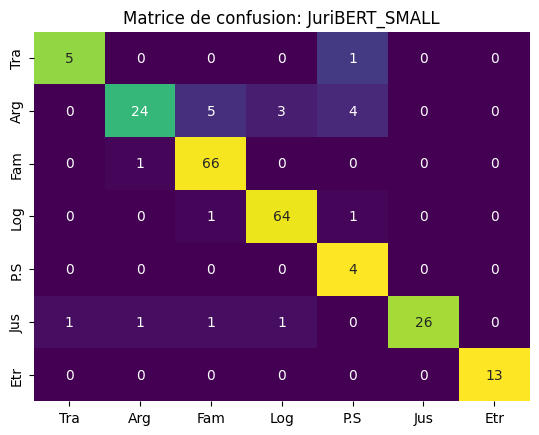

In [44]:

# Remplacez ces noms par vos vrais noms de catégories
category_names = ['Tra', 'Arg', 'Fam', 'Log', 'P.S', 'Jus', 'Etr']

plot_confusion_matrix(labels, juribert_preds, category_names)